# 📘 Machine Learning Regression Tutorial
Author: Ridwan Amure

We will examine the following:


- Ordinary Least Squares (OLS)
- Ridge Regression (L2)
- Lasso Regression (L1)
- Support Vector Regression (SVR)
- Decision Trees (Regression/CART)
- Ensembles (Bagging, Random Forest, Gradient Boosting)

**Learning goals**
- Understand each model’s **objective function**, **assumptions**, and **solution**.
- Implement simple **from-scratch** versions (for intuition).
- Train **sklearn** versions and compare results.
- Read basic **diagnostics** (residual plots, bias–variance intuition).


# 🔍 Differences Between Regression Algorithms

Regression algorithms all aim to **predict a continuous target**, but they differ in  
**assumptions, loss functions, regularization, and model complexity**.

---

## 1. Ordinary Least Squares (OLS)

**Objective**: Minimize squared error  

$$
\min_{\beta, b}\; \|y - (X\beta + b)\|_2^2
$$

- **Assumptions**: Linearity, no multicollinearity, homoscedastic errors.  
- **Pros**: Fast, interpretable, closed-form solution.  
- **Cons**: Sensitive to outliers & multicollinearity, no built-in regularization.  
- **Best for**: When you believe the relationship is linear and interpretability matters.

---

## 2. Ridge Regression (L2 Regularization)

**Objective**:  

$$
\min_{\beta, b}\; \|y - (X\beta + b)\|_2^2 + \lambda \|\beta\|_2^2
$$

- **Effect**: Shrinks coefficients but keeps all variables.  
- **Pros**: Handles multicollinearity, reduces variance.  
- **Cons**: Doesn’t perform feature selection.  
- **Best for**: When predictors are highly correlated and you want stability.

---

## 3. Lasso Regression (L1 Regularization)

**Objective**:  

$$
\min_{\beta, b}\; \|y - (X\beta + b)\|_2^2 + \lambda \|\beta\|_1
$$

- **Effect**: Forces some coefficients to exactly zero → feature selection.  
- **Pros**: Sparse solution, good for high-dimensional data.  
- **Cons**: Can be unstable if features are highly correlated.  
- **Best for**: When you want automatic variable selection.

---

## 4. Support Vector Regression (SVR)

**Objective**: Fit a flat function within an $\epsilon$-tube; penalize deviations $>\epsilon$  

$$
\min_{w,b,\xi,\xi^*}\; \tfrac{1}{2}\|w\|_2^2 + C\sum (\xi_i+\xi_i^*)
$$

- **Effect**: Ignores small errors, focuses on support vectors near boundary.  
- **Pros**: Robust to outliers, powerful with non-linear kernels (e.g., RBF).  
- **Cons**: Slower on large datasets, sensitive to hyperparameters.  
- **Best for**: Small/medium datasets with complex non-linear relations.

---

## 5. Decision Trees for Regression

**Objective**: Recursively split data to minimize variance (MSE).  

- **Effect**: Piecewise constant approximations of the target.  
- **Pros**: Handles non-linearities, interactions, missing values; interpretable.  
- **Cons**: High variance, overfits without pruning.  
- **Best for**: Data with strong non-linear interactions; when interpretability is important.

---

## 6. Ensemble Methods (Random Forest, Gradient Boosting)

- **Random Forest (Bagging + Trees)**: Average many trees → lower variance, robust.  
- **Gradient Boosting**: Sequentially fit trees to residuals → lower bias.  

- **Pros**: State-of-the-art for tabular data; handle complex patterns.  
- **Cons**: Less interpretable, more computationally expensive.  
- **Best for**: When predictive accuracy is the top priority.

---

# ⚖️ Summary of Key Differences

| Algorithm        | Handles Non-Linearity | Regularization | Feature Selection | Robust to Outliers | Interpretability | Typical Use Case |
|------------------|------------------------|----------------|-------------------|--------------------|------------------|------------------|
| OLS              | ❌ Linear only         | ❌ None         | ❌                | ❌                 | ✅ High          | Simple baseline, inference |
| Ridge            | ❌ Linear only         | ✅ L2           | ❌                | ❌                 | ✅ High          | Multicollinearity control |
| Lasso            | ❌ Linear only         | ✅ L1           | ✅ Yes            | ❌                 | ✅ High          | Variable selection |
| SVR (RBF)        | ✅ Yes (with kernel)   | ✅ (via C, ε)   | ❌                | ✅                 | ⚠️ Medium        | Small/medium non-linear data |
| Decision Tree    | ✅ Yes                 | ⚠️ Pruning      | ✅ Implicit splits| ❌                 | ✅ Medium        | Non-linear tabular data |
| Ensembles (RF/GB)| ✅ Yes                 | ✅ Implicit     | ❌                | ✅                 | ❌ Low           | High accuracy, robustness |

---

👉 **In short**:  
- **OLS/Ridge/Lasso** → linear world (fast, interpretable).  
- **SVR** → kernel trick for non-linear cases.  
- **Trees/Ensembles** → flexible non-parametric methods, often best for real-world tabular data.



## 0. Notation & Setup

- \(X \in \mathbb{R}^{n \times d}\): feature matrix (rows = samples, cols = features)  
- \(y \in \mathbb{R}^{n}\): target vector  
- \(\beta \in \mathbb{R}^{d}\): weight vector (coefficients)  
- \(b \in \mathbb{R}\): intercept/bias  
- Prediction: \(\hat{y} = X\beta + b\)

We’ll generate synthetic data (with a non-linear twist) and keep both **raw** and **standardized** versions for algorithms that benefit from scaling.


In [33]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rng = np.random.default_rng(42)

def rmse(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

def print_metrics(name, y_true, y_pred):
    print(f"{name:>28} | RMSE: {rmse(y_true,y_pred):.4f} | MAE: {mean_absolute_error(y_true,y_pred):.4f} | R²: {r2_score(y_true,y_pred):.4f}")



## 1. Data (Synthetic)

We create a regression dataset with noise and **add a sinusoidal non-linearity** so that non-linear models (SVR with RBF, trees, ensembles) have a chance to shine.

We’ll keep both **original** and **standardized** copies:
- Scaling is **important** for L1/L2-regularized models and SVR.


In [29]:

# Base linear data
X, y = make_regression(
    n_samples=2000, n_features=10, n_informative=8, noise=15.0, random_state=42
)
# Add non-linear twist
y = y + 25.0 * np.sin(X[:, 0])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Standardize (for SVR/Lasso and often helpful generally)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_test_s  = scaler_X.transform(X_test)
y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()
y_test_s  = scaler_y.transform(y_test.reshape(-1,1)).ravel()

X_train.shape, X_test.shape


((1500, 10), (500, 10))


## 2. Ordinary Least Squares (OLS)

### 📖 Theory

**Model**: $$ \hat{y} = X\beta + b $$

**Objective** (sum of squared errors, SSE):
$$
\min_{\beta,b}\; \|y - (X\beta + b\mathbf{1})\|_2^2
$$

Augment $X$ with a bias column $ \mathbf{1} $ to get $X_b=[\mathbf{1}\,|\,X]$ and parameter vector $\theta=[b;\beta]$:
$$
\min_{\theta}\; \|y - X_b\theta\|_2^2.
$$

**Normal Equations (derivation)**: set gradient to zero
$$
-2 X_b^\top (y - X_b\theta) = 0
\Rightarrow X_b^\top X_b\,\hat{\theta} = X_b^\top y
\Rightarrow \hat{\theta} = (X_b^\top X_b)^{-1} X_b^\top y,
$$
or use pseudo-inverse if $X_b^\top X_b$ is singular.

**Assumptions**: linearity, i.i.d. errors, zero-mean errors, homoscedasticity, no perfect multicollinearity, (normal errors for classical inference).

**Diagnostics**: residual plots should show no strong patterns; look for heteroscedasticity and outliers.


In [34]:

class OLSFromScratch:
    def fit(self, X, y):
        Xb = np.c_[np.ones((X.shape[0], 1)), X]
        self.theta_ = np.linalg.pinv(Xb) @ y
        return self
    def predict(self, X):
        Xb = np.c_[np.ones((X.shape[0], 1)), X]
        return Xb @ self.theta_

ols_fs = OLSFromScratch().fit(X_train, y_train)
y_pred_ols_fs = ols_fs.predict(X_test)
print_metrics("OLS (from scratch)", y_test, y_pred_ols_fs)

ols_sk = LinearRegression().fit(X_train, y_train)
y_pred_ols_sk = ols_sk.predict(X_test)
print_metrics("OLS (sklearn)", y_test, y_pred_ols_sk)


          OLS (from scratch) | RMSE: 15.2021 | MAE: 12.2678 | R²: 0.9937
               OLS (sklearn) | RMSE: 15.2021 | MAE: 12.2678 | R²: 0.9937


# Alternatively

# LINEAR REGRESSION MODEL

The linear regression model is of the form ;

 y = mx + k         ---- 1

 where  y is the target, x is the variable or feature , m is the weight or gradient or slope and c is the y-intercept or bias.

The equation 1 above is suitable for one variable linear regression, however it can be expanded to support multiple variables. This is given in equation 2 below

y = m_i x_i + m_2 x_2 + m_3x_3 + ... m_n x_n +k     </t>  ------   2

The process of deeloping this model as a machine learning algorithm is divided into stages

##  1.1 Forward propagation
###  1.1.1 Initialise weights
The weight m of the model is first initialized. There are diferent approach to this process. In this implementation, the weights are initialised randomly

### 1.1.2 Feed data
The data (X) is fed to the model (fitted). This is done in batches. The fitting is done by multiplying the weight m for each feature by the corresponding value in the data.
### 1.1.3 Compute ŷ
The target ŷ is computed by summing the ouputs of step 1.1.2

### 1.1.4 Compute loss
The mean squared error is calculated across the batch using the formular below:

L = (1/N) * Σ(y - ŷ)^2

* L is the loss.
* N is the number of data points.
* y is the actual target value.
* ŷ is the predicted target value.

## 1.2 Backpropagation

### 1.2.1 Compute partial differentials

To update the weights,  the partial derivatives of the loss function with respect to each weight is computed.  This indicates how the loss changes with respect to each weight parameter.
Since the loss is a function of y and y is a function of the paramters, we use chain rules to calculate the partial derivatives of the loss with respect to the parameters. For example to calcualte the partial derivatives of L with respect to k

∂L/∂k = ∂L/∂ŷ  *  ∂ŷ/∂k

The other derivatives are calculated in a similar fashion

### 1.2.3 Update weights

**Update for Bias Term (k)**

The derivative of the loss with respect to the bias term k (constant) is straightforward:

∂L/∂k = -2 * Σ(y - ŷ)

**Update for Weight Parameters (param)**

∂L/∂w_i = -2 * Σ(y - ŷ) * x_i

**Gradient Descent Update**

After computing the gradients for all weights, you update the weights using gradient descent:

k = k - learning_rate * ∂L/∂k

w_i = w_i - learning_rate * ∂L/∂w_i

This process is repeated for multiple iteration to obtain the best parameters.


In [30]:
from typing import Union
import numpy as np

class LinearRegression:
    def __init__(self, lr=0.001, num_epochs=1000):
        self.lr = lr # the learning rate
        self.num_epochs = num_epochs # number of iteration

    def initialize_parameters(self, X):
        # get the number of features; check if X is a list or a numpy array
        if isinstance(X,list):
          assert isinstance(X[0],Union(list,np.ndarray)) , "Expected a 2 dimensional list" # verify the nature of the data

          X = np.array(X)

        self.X = X
        n_features = X.shape[1] if len(X.shape)>=2 else 1
        self.param = np.random.rand(n_features)
        self.k = 0

    def get_loss(self, y, y_pred):
        '''
        The funtion calculate the mean squared error loss
        ---------------
        input: y and predicted y

        output : loss
        '''
        return np.mean((y - y_pred) ** 2)

    def update_params(self, X_batch, y_batch, y_pred):
        '''
        This function calculate the partial differentials of y with respect to the weight of each parameter.
        see discussion above for more details
        '''
        dl_dy = -2 * (y_batch - y_pred)  # getting the partial differential of the loss function with respect to y
        self.k -= self.lr * np.mean(dl_dy) #updating k; using chain rule of differentiation, see above discussion for more details
        self.param -= self.lr * np.mean(X_batch * dl_dy[:, np.newaxis], axis=0)

    def fit(self, X, y, return_loss_values=False):
        loss_values = {}
        y = np.array(y)
        batch_size = 1
        self.initialize_parameters(X)
        for epoch in range(self.num_epochs):
            loss_list =[]
            for i in range(0, self.X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                y_pred = np.dot(X_batch, self.param) + self.k
                loss = self.get_loss(y_batch, y_pred)
                loss_list.append(loss)
                self.update_params(X_batch, y_batch, y_pred)
                # print(f"Epoch {epoch}, Loss {loss:.4f}")
            loss_values[epoch] = np.mean(loss_list)
        if return_loss_values:
          return loss_values

    def predict(self, X):
        X = np.array(X)
        return np.dot(X, self.param) + self.k

lr = LinearRegression(lr=0.002) # initialize model
loss_values = lr.fit(X_train, y_train, return_loss_values=True) # fit the model
print_metrics("OLS (something something something easier approach)", y_test, lr.predict(X_test))


OLS (something something something easier approach) | RMSE: 15.2851 | MAE: 12.2720 | R²: 0.9937


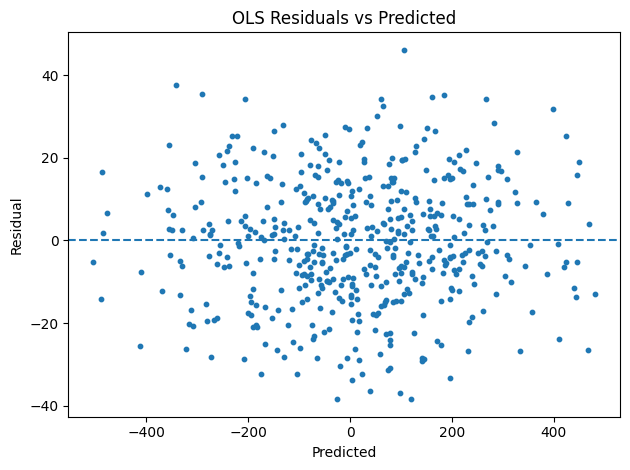

In [31]:

# Residual diagnostic
resid = y_test - y_pred_ols_sk
plt.figure()
plt.scatter(y_pred_ols_sk, resid, s=10)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("OLS Residuals vs Predicted")
plt.tight_layout()
plt.show()



## 3. Ridge Regression (L2)

### 📖 Theory

**Objective**:
$$
\min_{\beta,b}\; \|y - (X\beta + b\mathbf{1})\|_2^2 \;+\; \lambda \|\beta\|_2^2
$$

- Penalizes large coefficients → reduces variance and handles multicollinearity.
- Do **not** penalize intercept \(b\).

**Closed-form (unpenalized intercept)**:
$$
\hat{\theta} = (X_b^\top X_b + \lambda D)^{-1} X_b^\top y,\quad D=\mathrm{diag}(0,1,\ldots,1).
$$

**Bias–variance trade-off**: as \(\lambda\uparrow\), coefficients shrink, variance drops, bias increases.


In [35]:

class RidgeFromScratch:
    def __init__(self, lam=10.0): self.lam = lam
    def fit(self, X, y):
        Xb = np.c_[np.ones((X.shape[0], 1)), X]
        D = np.eye(Xb.shape[1]); D[0,0] = 0.0
        self.theta_ = np.linalg.pinv(Xb.T @ Xb + self.lam * D) @ (Xb.T @ y)
        return self
    def predict(self, X):
        Xb = np.c_[np.ones((X.shape[0], 1)), X]
        return Xb @ self.theta_

ridge_fs = RidgeFromScratch(lam=10.0).fit(X_train, y_train)
y_pred_ridge_fs = ridge_fs.predict(X_test)
print_metrics("Ridge (from scratch, lam=10)", y_test, y_pred_ridge_fs)

ridge_sk = Ridge(alpha=10.0).fit(X_train, y_train)
y_pred_ridge_sk = ridge_sk.predict(X_test)
print_metrics("Ridge (sklearn, alpha=10)", y_test, y_pred_ridge_sk)


Ridge (from scratch, lam=10) | RMSE: 15.2845 | MAE: 12.2755 | R²: 0.9937
   Ridge (sklearn, alpha=10) | RMSE: 15.2845 | MAE: 12.2755 | R²: 0.9937



## 4. Lasso Regression (L1)

### 📖 Theory

**Objective**:
$$
\min_{\beta,b}\; \frac{1}{2n}\|y - (X\beta + b\mathbf{1})\|_2^2 \;+\; \alpha \|\beta\|_1
$$

- L1 penalty promotes **sparsity** → some coefficients become exactly zero.
- Solutions via **coordinate descent**, **proximal gradient**, or **LARS**.
- **Standardize** features before fitting.

**Soft-thresholding** in coordinate updates:
$$
S(z, \gamma) = \mathrm{sign}(z)\max(|z| - \gamma, 0).
$$


In [36]:

class LassoFromScratch:
    def __init__(self, lam=0.2, max_iter=3000, tol=1e-6):
        self.lam = lam; self.max_iter = max_iter; self.tol = tol

    @staticmethod
    def soft(z, g):
        if z > g:   return z - g
        if z < -g:  return z + g
        return 0.0

    def fit(self, X, y):
        self.X_mean_ = X.mean(axis=0)
        self.X_std_  = X.std(axis=0) + 1e-12
        Xs = (X - self.X_mean_) / self.X_std_
        y_mean = y.mean()
        ys = y - y_mean

        n, d = Xs.shape
        w = np.zeros(d)
        Xcol2 = (Xs**2).sum(axis=0)

        for _ in range(self.max_iter):
            w_old = w.copy()
            for j in range(d):
                r_j = ys - Xs @ w + Xs[:, j] * w[j]
                rho = (Xs[:, j] * r_j).sum()
                w[j] = self.soft(rho / Xcol2[j], self.lam / (2.0 * Xcol2[j]))
            if np.linalg.norm(w - w_old) < self.tol:
                break

        self.coef_ = w / self.X_std_
        self.intercept_ = y_mean - self.X_mean_ @ self.coef_
        return self

    def predict(self, X):
        return self.intercept_ + X @ self.coef_

lasso_fs = LassoFromScratch(lam=0.2, max_iter=3000).fit(X_train, y_train)
y_pred_lasso_fs = lasso_fs.predict(X_test)
print_metrics("Lasso (from scratch, lam=0.2)", y_test, y_pred_lasso_fs)

lasso_sk = Lasso(alpha=0.2, max_iter=10000).fit(X_train_s, y_train_s)
y_pred_lasso_sk = scaler_y.inverse_transform(lasso_sk.predict(X_test_s).reshape(-1,1)).ravel()
print_metrics("Lasso (sklearn, alpha=0.2)", y_test, y_pred_lasso_sk)


Lasso (from scratch, lam=0.2) | RMSE: 15.2021 | MAE: 12.2678 | R²: 0.9937
  Lasso (sklearn, alpha=0.2) | RMSE: 89.2390 | MAE: 71.4214 | R²: 0.7838



## 5. Support Vector Regression (SVR)

### 📖 Theory

**Primal (linear SVR)**:
$$
\min_{w,b,\xi,\xi^*} \frac{1}{2}\|w\|_2^2 + C\sum_i(\xi_i+\xi_i^*) \quad
\text{s.t.}\; y_i - (w^\top x_i + b) \le \epsilon + \xi_i,\; (w^\top x_i + b) - y_i \le \epsilon + \xi_i^*,\; \xi_i,\xi_i^*\ge 0.
$$

- $\epsilon$-insensitive loss ignores small deviations.  
- Use kernels (e.g., **RBF**) for non-linear relations.


In [37]:

svr_sk = SVR(C=5.0, epsilon=0.2, kernel='rbf', gamma='scale')
svr_sk.fit(X_train_s, y_train_s)
y_pred_svr_sk = scaler_y.inverse_transform(svr_sk.predict(X_test_s).reshape(-1,1)).ravel()
print_metrics("SVR (sklearn, RBF)", y_test, y_pred_svr_sk)


          SVR (sklearn, RBF) | RMSE: 39.9651 | MAE: 27.3796 | R²: 0.9566



## 6. Decision Tree Regression (CART)

### 📖 Theory

Split on feature \(j\) and threshold \(t\) to maximize reduction in **MSE**:
$$
\Delta = \mathrm{MSE}(S) - \frac{|S_L|}{|S|}\mathrm{MSE}(S_L) - \frac{|S_R|}{|S|}\mathrm{MSE}(S_R).
$$

- Control depth/min samples to avoid overfitting.
- Great with ensembles.


In [38]:

tree_sk = DecisionTreeRegressor(max_depth=6, min_samples_split=20, random_state=42)
tree_sk.fit(X_train, y_train)
y_pred_tree = tree_sk.predict(X_test)
print_metrics("Decision Tree (sklearn)", y_test, y_pred_tree)


     Decision Tree (sklearn) | RMSE: 117.6169 | MAE: 91.6444 | R²: 0.6244


## simple experiment

[source](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html)

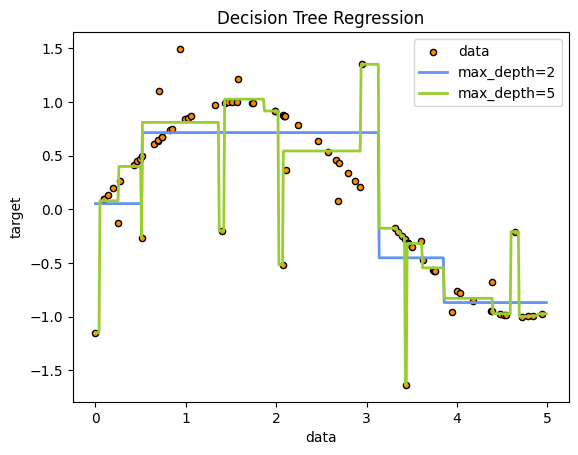

In [39]:
import numpy as np

rng = np.random.RandomState(1)
X_exp = np.sort(5 * rng.rand(80, 1), axis=0)
y_exp = np.sin(X_exp).ravel()
y_exp[::5] += 3 * (0.5 - rng.rand(16))


from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X_exp, y_exp)
regr_2.fit(X_exp, y_exp)

X_test_exp = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test_exp)
y_2 = regr_2.predict(X_test_exp)


import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X_exp, y_exp, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test_exp, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test_exp, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

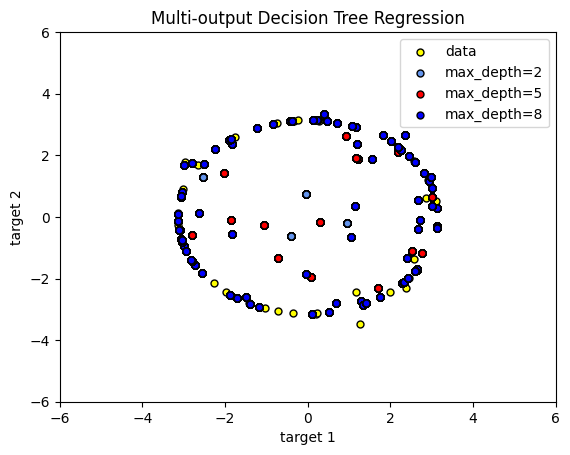

In [40]:
rng = np.random.RandomState(1)
X_exp = np.sort(200 * rng.rand(100, 1) - 100, axis=0)
y_exp = np.array([np.pi * np.sin(X_exp).ravel(), np.pi * np.cos(X_exp).ravel()]).T
y_exp[::5, :] += 0.5 - rng.rand(20, 2)

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=8)
regr_1.fit(X_exp, y_exp)
regr_2.fit(X_exp, y_exp)
regr_3.fit(X_exp, y_exp)

X_test_exp = np.arange(-100.0, 100.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test_exp)
y_2 = regr_2.predict(X_test_exp)
y_3 = regr_3.predict(X_test_exp)


plt.figure()
s = 25
plt.scatter(y_exp[:, 0], y_exp[:, 1], c="yellow", s=s, edgecolor="black", label="data")
plt.scatter(
    y_1[:, 0],
    y_1[:, 1],
    c="cornflowerblue",
    s=s,
    edgecolor="black",
    label="max_depth=2",
)
plt.scatter(y_2[:, 0], y_2[:, 1], c="red", s=s, edgecolor="black", label="max_depth=5")
plt.scatter(y_3[:, 0], y_3[:, 1], c="blue", s=s, edgecolor="black", label="max_depth=8")
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Multi-output Decision Tree Regression")
plt.legend(loc="best")
plt.show()


## 7. Ensembles

### 📖 Theory (quick)

- **Bagging**: average many base learners trained on bootstrapped samples → variance reduction.
- **Random Forest**: bagging + random feature subsampling per split → decorrelates trees.
- **Gradient Boosting**: fit trees sequentially to residuals (negative gradients) → bias reduction.


In [41]:

rf_sk  = RandomForestRegressor(n_estimators=150, max_depth=8, random_state=42, n_jobs=-1)
rf_sk.fit(X_train, y_train)
y_pred_rf = rf_sk.predict(X_test)
print_metrics("Random Forest (sklearn)", y_test, y_pred_rf)

gbrt_sk = GradientBoostingRegressor(random_state=42)
gbrt_sk.fit(X_train, y_train)
y_pred_gbrt = gbrt_sk.predict(X_test)
print_metrics("Gradient Boosting (sklearn)", y_test, y_pred_gbrt)


     Random Forest (sklearn) | RMSE: 66.5748 | MAE: 49.9050 | R²: 0.8797
 Gradient Boosting (sklearn) | RMSE: 41.1534 | MAE: 31.3428 | R²: 0.9540



## 8. Model Comparison


In [42]:

results = []
def add_result(name, y_true, y_pred):
    results.append({"Model": name, "RMSE": rmse(y_true, y_pred), "MAE": mean_absolute_error(y_true, y_pred), "R2": r2_score(y_true, y_pred)})

add_result("OLS (scratch)", y_test, y_pred_ols_fs)
add_result("OLS (sklearn)", y_test, y_pred_ols_sk)
add_result("Ridge (scratch,10)", y_test, y_pred_ridge_fs)
add_result("Ridge (sklearn,10)", y_test, y_pred_ridge_sk)
add_result("Lasso (scratch,0.2)", y_test, y_pred_lasso_fs)
add_result("Lasso (sklearn,0.2)", y_test, y_pred_lasso_sk)
add_result("SVR (sklearn RBF)", y_test, y_pred_svr_sk)
add_result("Tree (sklearn)", y_test, y_pred_tree)
add_result("Random Forest", y_test, y_pred_rf)
add_result("Gradient Boosting", y_test, y_pred_gbrt)

df_results = pd.DataFrame(results).sort_values("RMSE")
df_results


,Model,RMSE,MAE,R2
0,OLS (scratch),15.202125,12.267845,0.993725
1,OLS (sklearn),15.202125,12.267845,0.993725
4,"Lasso (scratch,0.2)",15.202135,12.267847,0.993725
2,"Ridge (scratch,10)",15.284465,12.275460,0.993657
3,"Ridge (sklearn,10)",15.284465,12.275460,0.993657
6,SVR (sklearn RBF),39.965090,27.379553,0.956634
9,Gradient Boosting,41.153402,31.342784,0.954017
8,Random Forest,66.574763,49.904955,0.879661
5,"Lasso (sklearn,0.2)",89.239032,71.421430,0.783780
7,Tree (sklearn),117.616872,91.644412,0.624399


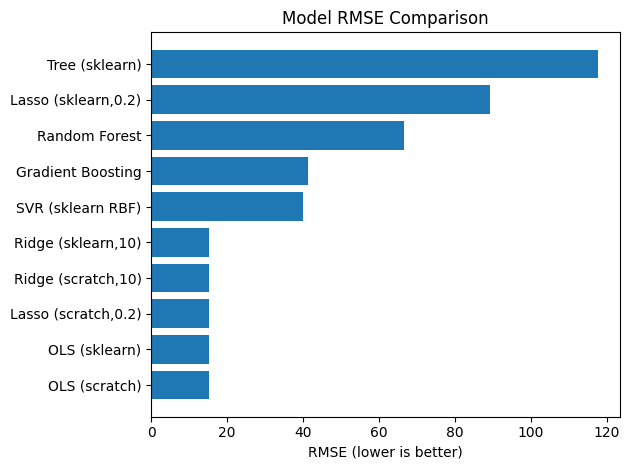

In [43]:

# RMSE comparison
plt.figure()
plt.barh(df_results["Model"], df_results["RMSE"])
plt.xlabel("RMSE (lower is better)")
plt.title("Model RMSE Comparison")
plt.tight_layout()
plt.show()


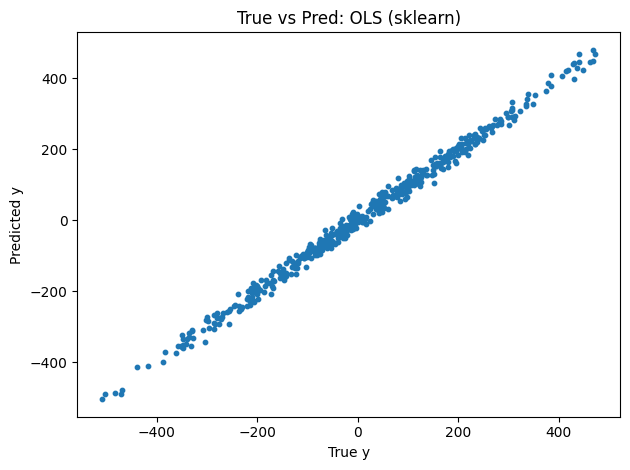

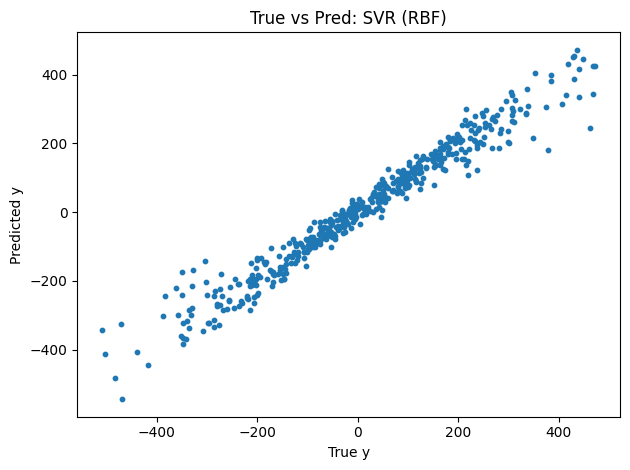

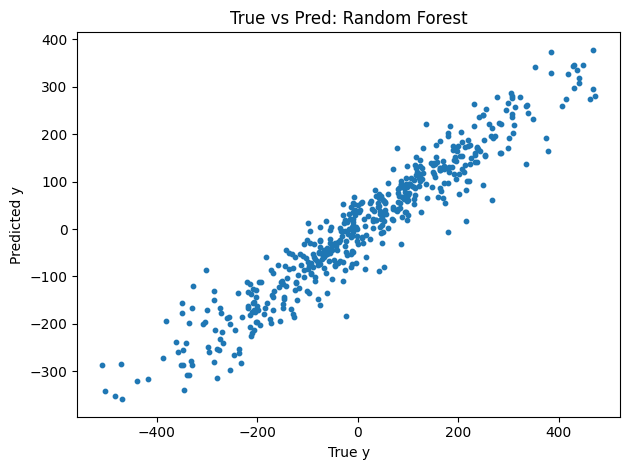

In [27]:

# True vs Pred plots
def plot_true_vs_pred(y_true, y_pred, title):
    plt.figure()
    plt.scatter(y_true, y_pred, s=10)
    plt.xlabel("True y")
    plt.ylabel("Predicted y")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_true_vs_pred(y_test, y_pred_ols_sk, "True vs Pred: OLS (sklearn)")
plot_true_vs_pred(y_test, y_pred_svr_sk, "True vs Pred: SVR (RBF)")
plot_true_vs_pred(y_test, y_pred_rf,    "True vs Pred: Random Forest")



## 9. When to Use What (Cheat Sheet)

- **OLS**: strong linear signal, interpretability matters; baseline.
- **Ridge**: multicollinearity, need coefficient stability without sparsity.
- **Lasso**: feature selection via sparsity; standardize features.
- **SVR (RBF)**: complex non-linear structure, small/medium n; tune \(C,\epsilon,\gamma\).
- **Decision Trees**: interpretable non-linear splits; limit depth or ensemble.
- **RF/GBRT**: robust and powerful on tabular data; tune hyperparameters via cross-validation.

**Best practices**
- Start simple, inspect residuals.
- Scale features for L1/L2/SVR.
- Use cross-validation for hyperparameters.
